## Crop yields and production

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Data source: http://data.icrisat.org/dld/src/crops.html

In [2]:
df = pd.read_csv("crops/ICRISAT-District Level Data.csv")
df.head(3)

,Dist Code,Year,State Code,State Name,Dist Name,RICE AREA (1000 ha),RICE PRODUCTION (1000 tons),RICE YIELD (Kg per ha),WHEAT AREA (1000 ha),WHEAT PRODUCTION (1000 tons),...,SUGARCANE YIELD (Kg per ha),COTTON AREA (1000 ha),COTTON PRODUCTION (1000 tons),COTTON YIELD (Kg per ha),FRUITS AREA (1000 ha),VEGETABLES AREA (1000 ha),FRUITS AND VEGETABLES AREA (1000 ha),POTATOES AREA (1000 ha),ONION AREA (1000 ha),FODDER AREA (1000 ha)
0,64,1966,5,Karnataka,Bangalore,45.0,65.0,1444.44,0.0,0.0,...,19060.61,0.0,0.0,0.0,6.39,4.95,11.34,1.79,0.37,5.36
1,64,1967,5,Karnataka,Bangalore,36.0,21.0,583.33,0.0,0.0,...,19481.48,0.0,0.0,0.0,5.50,4.15,9.65,1.70,0.59,6.04
2,64,1968,5,Karnataka,Bangalore,35.3,43.0,1218.13,0.4,0.0,...,8676.47,0.0,0.0,0.0,5.37,4.02,9.39,1.59,0.61,6.08


In [3]:
# Combine all districts (Dist Name column) into one row per state per year
dfg = df.groupby(['State Name', 'Year']).sum().reset_index()
# Drop State Name, Dist Code, State Code and Dist Name columns
dfg = dfg.drop(['State Name', 'Dist Code', 'State Code', 'Dist Name'], axis=1)

In [4]:
# We're going from wide to long format
# First, drop all the columns with "YIELD" in the column name
dft = dfg.drop([col for col in dfg.columns if 'YIELD' in col], axis=1)
dft.head()

# Now split the dataframe into two dataframes, one for area and one for production
dfa = dft.drop([col for col in dft.columns if 'PROD' in col], axis=1)
dfp = dft.drop([col for col in dft.columns if 'AREA' in col], axis=1)

# Drop the " AREA (1000 ha)" and " PROD (1000 tons)" suffixes from the column names using remove_suffix() and capatilize the column names
dfa = dfa.rename(columns=lambda x: x.removesuffix(' AREA (1000 ha)').capitalize())
dfp = dfp.rename(columns=lambda x: x.removesuffix(' PRODUCTION (1000 tons)').capitalize())

# Drop Fruits and vegetables (combination) and Barley (0 production) columns from the dataframe.
dfa = dfa.drop(['Fruits and vegetables', 'Barley'], axis="columns")
dfp = dfp.drop(['Barley'], axis="columns")

dfp.head(3)

,Year,Rice,Wheat,Kharif sorghum,Rabi sorghum,Sorghum,Pearl millet,Maize,Finger millet,Chickpea,...,Sesamum,Rapeseed and mustard,Safflower,Castor,Linseed,Sunflower,Soyabean,Oilseeds,Sugarcane,Cotton
0,1966,1649.0,43.3,643.5,748.0,1391.5,147.5,15.3,699.0,57.1,...,15.6,0.5,18.22,11.9,10.8,0.0,0.0,626.11,792.3,49.3
1,1967,1432.6,105.6,810.3,629.6,1439.9,168.1,50.4,603.0,66.1,...,19.8,0.5,22.79,9.6,14.0,0.0,0.0,661.54,865.6,49.6
2,1968,1941.0,157.4,874.2,768.2,1642.4,155.1,107.9,523.9,76.4,...,17.8,1.5,23.42,18.9,12.7,0.0,0.0,709.83,945.7,60.3


In [5]:
# Now we can melt the dataframes into long format
dfam = dfa.melt(id_vars=['Year'], var_name='Crop', value_name='Area (1000 ha)')
dfpm = dfp.melt(id_vars=['Year'], var_name='Crop', value_name='Production (1000 tons)')

# Merge the two dataframes into one
dfm = pd.merge(dfam, dfpm, on=['Year', 'Crop'], how='outer')

# Calculate yield
dfm['Yield (tons/ha)'] = dfm['Production (1000 tons)'] / dfm['Area (1000 ha)']
dfm.head(3)

,Year,Crop,Area (1000 ha),Production (1000 tons),Yield (tons/ha)
0,1966,Rice,1192.0,1649.0,1.383389
1,1967,Rice,1118.3,1432.6,1.281052
2,1968,Rice,1122.0,1941.0,1.729947


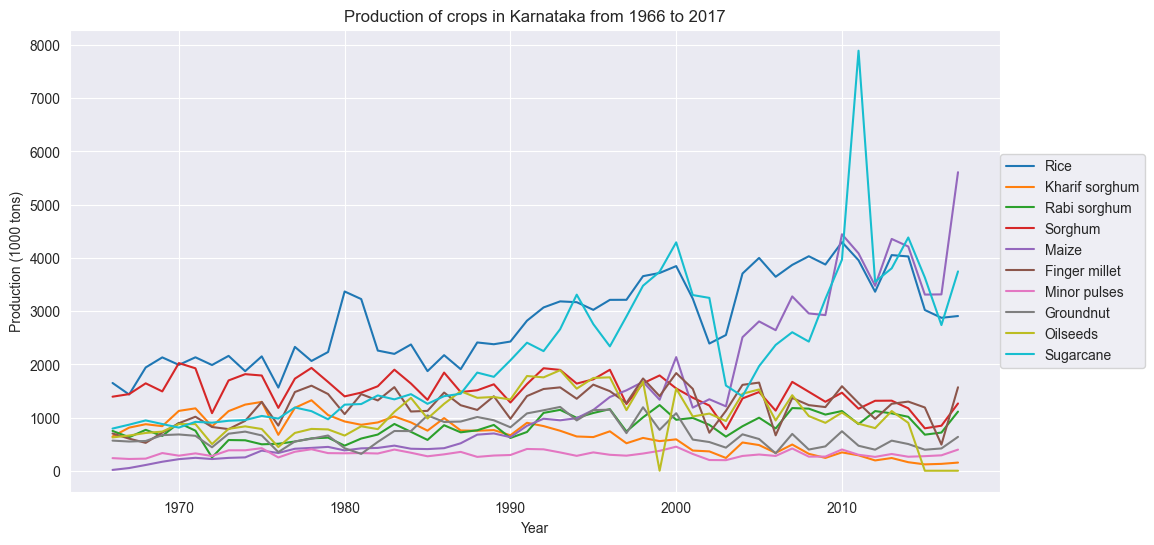

In [6]:
# Plot the Production over time for the 10 most produced crops.
# First, create a dataframe with the total production for each crop
dfp = dfm.groupby('Crop').sum().reset_index()
# Sort the dataframe by production
dfp = dfp.sort_values('Production (1000 tons)', ascending=False)
# Create a list of the 10 most produced crops
top10 = dfp['Crop'].head(10).tolist()
# Create a dataframe with the production for the 10 most produced crops
dfp10 = dfm[dfm['Crop'].isin(top10)]
# Plot the production over time for the 10 most produced crops
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Production (1000 tons)', hue='Crop', data=dfp10, palette='tab10', errorbar=None)
# Legend outside the plot
plt.legend(bbox_to_anchor=(1, 0.5), loc=6, borderaxespad=0.)
plt.title('Production of crops in Karnataka from 1966 to 2017')
plt.ylabel('Production (1000 tons)')
plt.savefig('images/production_lineplot.svg', format='svg', bbox_inches='tight')

### Mean Production, Yield and Area tables

In [7]:
# Create a dataframe with the total production, area and yield for each crop, using the average over the last 10 years.
# First, create a dataframe with the average production, area and yield for each crop over the last 10 years
df10 = dfm[dfm['Year'] >= 2008].groupby('Crop').mean().reset_index().drop('Year', axis=1)
# Sort the dataframe by production
df10 = df10.sort_values('Production (1000 tons)', ascending=False)
# Save the dataframe as a csv file
df10.to_csv('crops/mean_production_yield_area_2008_2017.csv', index=False)
# Color the dataframe
df10.style.background_gradient(cmap='Blues', subset=['Area (1000 ha)', 'Production (1000 tons)', 'Yield (tons/ha)'])

,Crop,Area (1000 ha),Production (1000 tons),Yield (tons/ha)
23,Sugarcane,481.410000,3936.947000,8.118180
9,Maize,1287.982000,3869.295000,2.997247
18,Rice,1303.924000,3640.639000,2.797275
21,Sorghum,1172.406000,1212.430000,1.031620
3,Finger millet,718.546000,1206.946000,1.664333
16,Rabi sorghum,1007.401000,993.780000,0.984626
11,Oilseeds,1267.125000,672.662000,0.531186
1,Chickpea,1000.281000,596.882000,0.598211
14,Pigeonpea,782.758000,546.495000,0.663323
6,Groundnut,689.025000,497.855000,0.734611


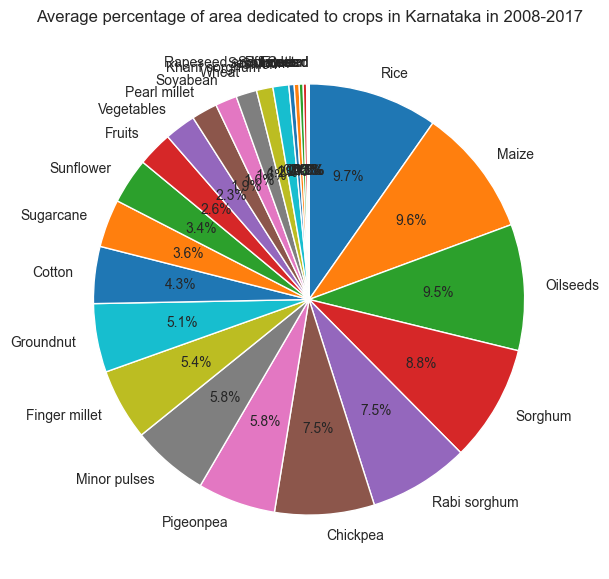

In [8]:
# Calculate the percentage of the area for each crop, and sort the dataframe by area
df10['Area (%)'] = df10['Area (1000 ha)'] / df10['Area (1000 ha)'].sum() * 100
df10 = df10.sort_values('Area (%)', ascending=False)

# Create a pie chart of the area percentage
plt.figure(figsize=(7, 7))
plt.pie(df10['Area (%)'], labels=df10['Crop'], autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Average percentage of area dedicated to crops in Karnataka in 2008-2017')
# Save as svg
plt.savefig('images/area_farmland_pie.svg', format='svg', bbox_inches='tight')

### Prices

In [9]:
prices = pd.read_csv("crops/ICRISAT-District Level Data - Harvest Price.csv")
prices.head(3)

,Dist Code,Year,State Code,State Name,Dist Name,RICE HARVEST PRICE (Rs per Quintal),PADDY HARVEST PRICE (Rs per Quintal),WHEAT HARVEST PRICE (Rs per Quintal),SORGHUM HARVEST PRICE (Rs per Quintal),PEARL MILLET HARVEST PRICE (Rs per Quintal),...,BARLEY HARVEST PRICE (Rs per Quintal),CHICKPEA HARVEST PRICE (Rs per Quintal),PIGEONPEA HARVEST PRICE (Rs per Quintal),GROUNDNUT HARVEST PRICE (Rs per Quintal),SEASMUM HARVEST PRICE (Rs per Quintal),RAPE AND MUSTARD HARVEST PRICE (Rs per Quintal),CASTOR HARVEST PRICE (Rs per Quintal),LINSEED HARVEST PRICE (Rs per Quintal),SUGARCANE GUR HARVEST PRICE (Rs per Quintal),COTTON KAPAS HARVEST PRICE (Rs per Quintal)
0,64,1966,5,Karnataka,Bangalore,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,64,1967,5,Karnataka,Bangalore,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,64,1968,5,Karnataka,Bangalore,-1.0,70.4,-1.0,66.5,-1.0,...,-1.0,130.8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [10]:
# Replace -1 with NaN
prices = prices.replace(-1, np.nan)

# Drop State Name, Dist Code, State Code and Dist Name columns
prices = prices.drop(['Dist Code', 'State Code', 'Dist Name'], axis=1)

# Combine all districts (Dist Name column) into one row per state per year
pricesg = prices.groupby(['State Name', 'Year']).mean().reset_index()

# Drop State Name column
pricesg = pricesg.drop(['State Name'], axis=1)

# Remove the " PRICE (Rs/quintal)" suffix from the column names using remove_suffix() and capatilize the column names
pricesg = pricesg.rename(columns=lambda x: x.removesuffix(' HARVEST PRICE (Rs per Quintal)').capitalize())

# Drop all columns in which more than half of the values is missing, and print which columns were dropped
dropped = pricesg.columns[pricesg.isnull().sum() > len(pricesg)/2].tolist()
pricesg = pricesg.drop(dropped, axis=1)
print(f"Dropped columns: {dropped}")

# Rename Paddy to Rice
pricesg = pricesg.rename(columns={'Paddy': 'Rice'})
print(f"Renamed Paddy column to Rice")

Dropped columns: ['Rice', 'Barley', 'Rape and mustard']
Renamed Paddy column to Rice


In [11]:
pricesg.tail(3)

,Year,Rice,Wheat,Sorghum,Pearl millet,Maize,Finger millet,Chickpea,Pigeonpea,Groundnut,Seasmum,Castor,Linseed,Sugarcane gur,Cotton kapas
48,2014,1418.4,1980.833333,2156.666667,1188.4,1240.928571,1512.500000,3744.666667,4880.375,4187.818182,8474.857143,3284.5,NaN,NaN,4148.142857
49,2015,1649.9,2022.000000,1760.571429,1314.0,1388.066667,1509.625000,3004.000000,6630.875,4332.000000,6068.714286,3220.0,8500.0,NaN,4554.600000
50,2016,1942.6,2183.500000,2001.203333,1493.4,1451.928571,2278.055556,5495.125000,4649.250,4506.555556,5514.333333,2884.0,8500.0,NaN,5217.285714


Text(0, 0.5, 'Price (Rs/quintal)')

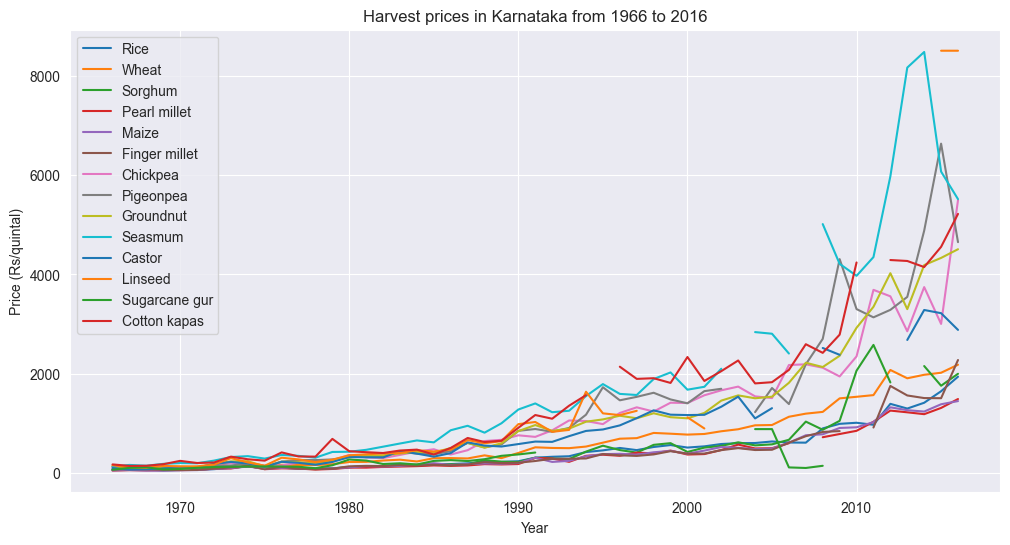

In [12]:
pricesg.plot(x='Year', figsize=(12, 6))
plt.title('Harvest prices in Karnataka from 1966 to 2016')
plt.ylabel('Price (Rs/quintal)')

### Combine harvest prices with production to calculate the value of the production

In [13]:
# Melt the dataframe into long format
pricesm = pricesg.melt(id_vars=['Year'], var_name='Crop', value_name='Price (Rs/quintal)')

# Merge the two dataframes into one
dfall = pd.merge(dfm, pricesm, on=['Year', 'Crop'], how='outer')

In [14]:
# Calculate the value of the production (1000 tons --> kg = * 1000000, Rs/quintal --> Rs/kg = / 100) = * 10000
dfall['Value (Rs)'] = dfall['Production (1000 tons)'] * dfall['Price (Rs/quintal)'] * 10000
dfall.tail(3)

,Year,Crop,Area (1000 ha),Production (1000 tons),Yield (tons/ha),Price (Rs/quintal),Value (Rs)
1554,2014,Cotton kapas,NaN,NaN,NaN,4148.142857,NaN
1555,2015,Cotton kapas,NaN,NaN,NaN,4554.600000,NaN
1556,2016,Cotton kapas,NaN,NaN,NaN,5217.285714,NaN


Create a CSV with for each crop the production, area, yield, price and value of the production with the 2010-2016 average

In [15]:
# For each crop, calculate the average production, area, yield, price and value of the production over the last 10 years
df10 = dfall[dfall['Year'] >= 2008].groupby('Crop').mean().reset_index().drop('Year', axis=1)

# Drop all crops (rows) for which the price is missing. Print the dropped crops.
dropped = df10[df10['Price (Rs/quintal)'].isnull()]['Crop'].tolist()
df10 = df10.dropna(subset=['Price (Rs/quintal)'])
print(f"{len(dropped)} crops dropped: {dropped}")

# Export the dataframe to a csv file
df10.to_csv('crops/agg_data.csv', index=False)

16 crops dropped: ['Cotton', 'Fodder', 'Fruits', 'Kharif sorghum', 'Minor pulses', 'Oilseeds', 'Onion', 'Potatoes', 'Rabi sorghum', 'Rapeseed and mustard', 'Safflower', 'Sesamum', 'Soyabean', 'Sugarcane', 'Sunflower', 'Vegetables']


### Value of production

In [16]:
# Only keep the Value column, and convert back to wide format
dfv = dfall[['Year', 'Crop', 'Value (Rs)']].pivot(index='Year', columns='Crop', values='Value (Rs)')

# Drop the last year (2017) because it is incomplete
dfv = dfv.drop(2017, axis=0)

# Drop all columns in which more than 50% of the values is missing, and print which columns were dropped
dropped = dfv.columns[dfv.isnull().sum() > len(dfv)*0.5].tolist()
dfv = dfv.drop(dropped, axis=1)
print(f"Dropped columns: {dropped}")

dfv.tail(3)

Dropped columns: ['Cotton', 'Cotton kapas', 'Fodder', 'Fruits', 'Kharif sorghum', 'Minor pulses', 'Oilseeds', 'Onion', 'Potatoes', 'Rabi sorghum', 'Rapeseed and mustard', 'Safflower', 'Seasmum', 'Sesamum', 'Soyabean', 'Sugarcane', 'Sugarcane gur', 'Sunflower', 'Vegetables']


Crop,Castor,Chickpea,Finger millet,Groundnut,Linseed,Maize,Pearl millet,Pigeonpea,Rice,Sorghum,Wheat
Year,,,,,,,,,,,
2014,238783150.0,2.334163e+10,1.964980e+10,2.101280e+10,NaN,5.228789e+10,2.954481e+09,2.313395e+10,5.712975e+10,2.530460e+10,5.152148e+09
2015,157780000.0,1.659620e+10,1.794310e+10,1.710230e+10,50150000.0,4.595195e+10,1.455255e+09,1.602351e+10,4.983737e+10,1.403211e+10,2.608582e+09
2016,135548000.0,3.256191e+10,1.119300e+10,1.886985e+10,13600000.0,4.812112e+10,3.817877e+09,5.636286e+10,5.583460e+10,1.693158e+10,3.743392e+09


Text(0, 0.5, 'Value (Rs)')

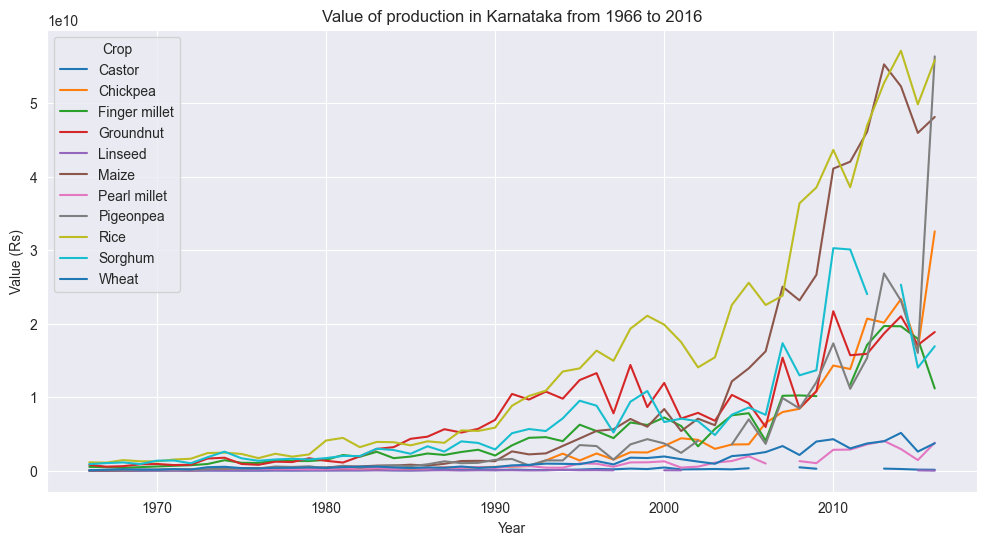

In [17]:
dfv.plot(figsize=(12, 6))
plt.title('Value of production in Karnataka from 1966 to 2016')
plt.ylabel('Value (Rs)')

Crops with 10% or more of the total value: ['Rice', 'Maize', 'Pigeonpea', 'Sorghum']


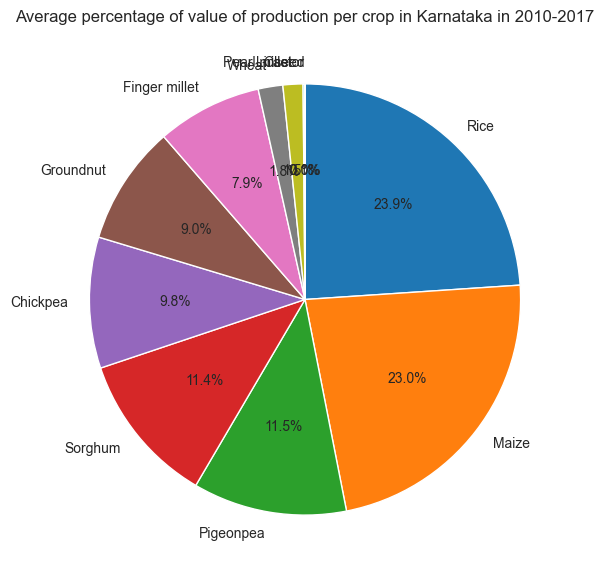

In [18]:
# Take the mean of the value of value for each crop over the last 10 years
dfv10 = dfv[dfv.index >= 2010].mean().reset_index().rename(columns={0: 'Value (Rs)'})
# Sort the dataframe by value
dfv10 = dfv10.sort_values('Value (Rs)', ascending=False)

# Print the crops with 10% or more of the total value, compared to the sum of all crops.
print(f"Crops with 10% or more of the total value: {dfv10[dfv10['Value (Rs)'] >= dfv10['Value (Rs)'].sum()*0.1]['Crop'].tolist()}")

# Create a pie chart of the value percentage
plt.figure(figsize=(7, 7))
plt.pie(dfv10['Value (Rs)'], labels=dfv10['Crop'], autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Average percentage of value of production per crop in Karnataka in 2010-2017')
# Save as svg
plt.savefig('images/value_pie.svg', format='svg', bbox_inches='tight')